# Stock Market Prediction using CNN-LSTM model
This project is about analysis of Stock Market and providing predictions to the stockholders. For this, we used CNN-LSTM approach to create a blank model, then use it to train on stock market data. Further implementation is discussed below...

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Preprocessing and Analysis

In [2]:
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

Before preprocessing data, a function to fetch real-time stock data (using Alpha Vantage API) is made

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
key = user_secrets.get_secret("api")

import requests
import csv
from tqdm import tqdm

def request_stock_price_list(symbol, size, token):
    q_string = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={}&outputsize={}&apikey={}'
    
    print("Retrieving stock price data from Alpha Vantage (This may take a while)...")
    r = requests.get(q_string.format(symbol, size, token))
    print("Data has been successfully downloaded...")
    date = []
    colnames = list(range(0, 7))
    df = pd.DataFrame(columns = colnames)
    print("Sorting the retrieved data into a dataframe...")
    for i in tqdm(r.json()['Time Series (Daily)'].keys()):
        date.append(i)
        row = pd.DataFrame.from_dict(r.json()['Time Series (Daily)'][i], orient='index').reset_index().T[1:]
        df = pd.concat([df, row], ignore_index=True)
    df.columns = ["open", "high", "low", "close", "adjusted close", "volume", "dividend amount", "split cf"]
    df['date'] = date
    return df

In [4]:
# UNCOMMENT THE CELL IF DATA IS NEEDED TO BE LOADED FOR 1ST TIME

cv1 = request_stock_price_list('IBM', 'full', key)
print(cv1.head)
cv1.to_csv('data.csv')

Retrieving stock price data from Alpha Vantage (This may take a while)...
Data has been successfully downloaded...
Sorting the retrieved data into a dataframe...


100%|██████████| 5571/5571 [02:13<00:00, 41.77it/s]


<bound method NDFrame.head of         open      high       low   close adjusted close    volume  \
0     125.72     127.2     124.7  127.06         127.06   4941411   
1     125.87    128.64  125.2093   127.4          127.4  10382693   
2     123.51  126.6399   123.475  125.93         125.93   7280537   
3      123.8   124.815    122.18  123.11         123.11   4990028   
4     122.35    125.03     122.3  123.76         123.76   5716124   
...      ...       ...       ...     ...            ...       ...   
5566   92.75     92.94     90.19   90.25  52.2266076272  13737600   
5567   94.44     94.44      90.0   91.56  52.9846891341  16697600   
5568   95.87     95.94      93.5   94.37  54.6108029006  10369100   
5569   96.75     96.81     93.69   94.81  54.8654256968  11105400   
5570    98.5     98.81     96.37   96.75  55.9880807527   9551800   

     dividend amount split cf        date  
0             0.0000      1.0  2021-12-20  
1             0.0000      1.0  2021-12-17  
2        

Then the datasets are loaded

In [5]:
# For data preprocessing and analysis part
data = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Stocks/abe.us.txt')
#data = pd.read_csv('../input/nifty50-stock-market-data/COALINDIA.csv')
#data = pd.read_csv('../input/stock-market-data/stock_market_data/nasdaq/csv/ABCO.csv')
#data = pd.read_csv('./data.csv')
# Any CSV or TXT file can be added here....
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,6.4987,6.6009,6.4668,6.5753,55766,0
1,2005-02-28,6.6072,6.7669,6.5944,6.6263,49343,0
2,2005-03-01,6.6391,6.6773,6.6072,6.6072,31643,0
3,2005-03-02,6.5753,6.6072,6.5434,6.5816,27101,0
4,2005-03-03,6.5753,6.6135,6.5562,6.5944,17387,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3190 entries, 0 to 3189
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     3190 non-null   object 
 1   Open     3190 non-null   float64
 2   High     3190 non-null   float64
 3   Low      3190 non-null   float64
 4   Close    3190 non-null   float64
 5   Volume   3190 non-null   int64  
 6   OpenInt  3190 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 174.6+ KB


In [7]:
data.describe()

,Open,High,Low,Close,Volume,OpenInt
count,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.0
mean,11.599416,11.712848,11.484610,11.605599,28444.870846,0.0
std,2.350376,2.365621,2.327065,2.341989,37525.175821,0.0
min,5.860300,5.905000,5.834700,5.841100,106.000000,0.0
25%,10.534000,10.655000,10.413750,10.554000,8147.750000,0.0
50%,11.981000,12.067000,11.899000,11.988500,17741.500000,0.0
75%,13.271000,13.386750,13.189000,13.295750,36167.250000,0.0
max,18.130000,19.151000,17.842000,17.925000,634041.000000,0.0


In [8]:
data.isnull().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

Filling null columns with mean values....

In [9]:
data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,6.4987,6.6009,6.4668,6.5753,55766,0
1,2005-02-28,6.6072,6.7669,6.5944,6.6263,49343,0
2,2005-03-01,6.6391,6.6773,6.6072,6.6072,31643,0
3,2005-03-02,6.5753,6.6072,6.5434,6.5816,27101,0
4,2005-03-03,6.5753,6.6135,6.5562,6.5944,17387,0


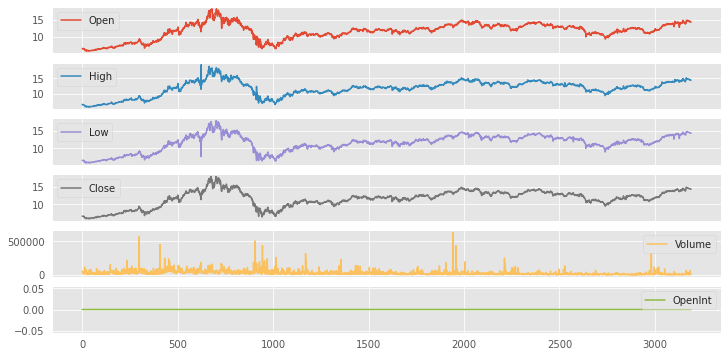

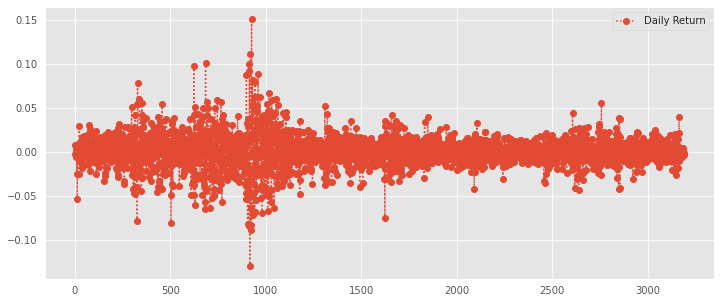

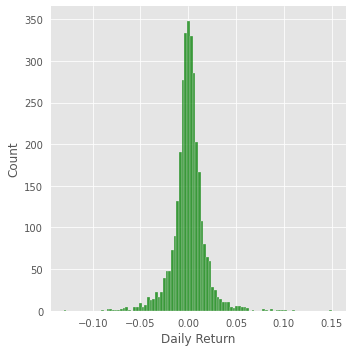

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


            Date     Open     High      Low    Close  Volume  OpenInt  \
0     2005-02-25   6.4987   6.6009   6.4668   6.5753   55766        0   
1     2005-02-28   6.6072   6.7669   6.5944   6.6263   49343        0   
2     2005-03-01   6.6391   6.6773   6.6072   6.6072   31643        0   
3     2005-03-02   6.5753   6.6072   6.5434   6.5816   27101        0   
4     2005-03-03   6.5753   6.6135   6.5562   6.5944   17387        0   
...          ...      ...      ...      ...      ...     ...      ...   
3185  2017-11-06  14.3998  14.4802  14.3900  14.4400   62423        0   
3186  2017-11-07  14.4400  14.4400  14.4000  14.4000    6722        0   
3187  2017-11-08  14.3400  14.4352  14.3400  14.3781    6304        0   
3188  2017-11-09  14.3300  14.3737  14.2800  14.3200   18761        0   
3189  2017-11-10  14.2500  14.3000  14.2400  14.3000   10658        0   

      MA for 10 days  MA for 50 days  MA for 100 days  Daily Return  
0           11.60878       11.625272        11.649354

Date               0
Open               0
High               0
Low                0
Close              0
Volume             0
OpenInt            0
MA for 10 days     0
MA for 50 days     0
MA for 100 days    0
Daily Return       0
dtype: int64

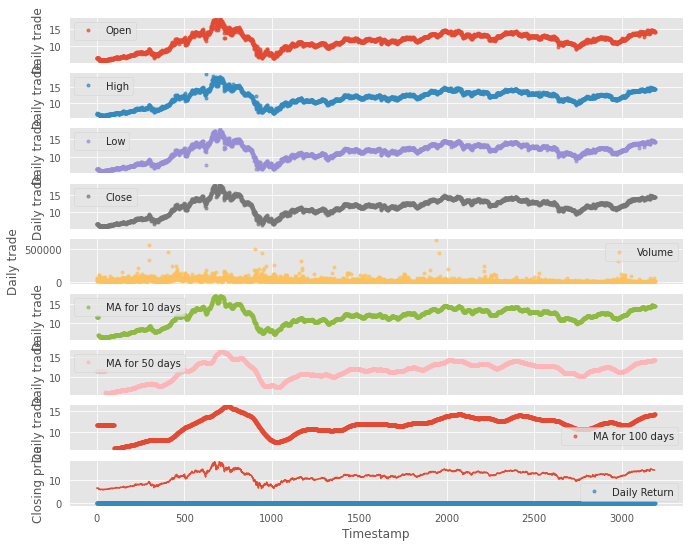

In [10]:
data.plot(legend=True,subplots=True, figsize = (12, 6))
plt.show()
#data['Close'].plot(legend=True, figsize = (12, 6))
#plt.show()
#data['Volume'].plot(legend=True,figsize=(12,7))
#plt.show()

data.shape
data.size
data.describe(include='all').T
data.dtypes
data.nunique()
ma_day = [10,50,100]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    data[column_name]=pd.DataFrame.rolling(data['Close'],ma).mean()

data['Daily Return'] = data['Close'].pct_change()
# plot the daily return percentage
data['Daily Return'].plot(figsize=(12,5),legend=True,linestyle=':',marker='o')
plt.show()

sns.displot(data['Daily Return'].dropna(),bins=100,color='green')
plt.show()

date=pd.DataFrame(data['Date'])
closing_df1 = pd.DataFrame(data['Close'])
close1  = closing_df1.rename(columns={"Close": "data_close"})
close2=pd.concat([date,close1],axis=1)
close2.head()

data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.head()

data.nunique()

data.sort_index(axis=1,ascending=True)

cols_plot = ['Open', 'High', 'Low','Close','Volume','MA for 10 days','MA for 50 days','MA for 100 days','Daily Return']
axes = data[cols_plot].plot(marker='.', alpha=0.7, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = data
print(df)

data.isnull().sum()

After that, we'll visualize the data for understanding, this is shown below...

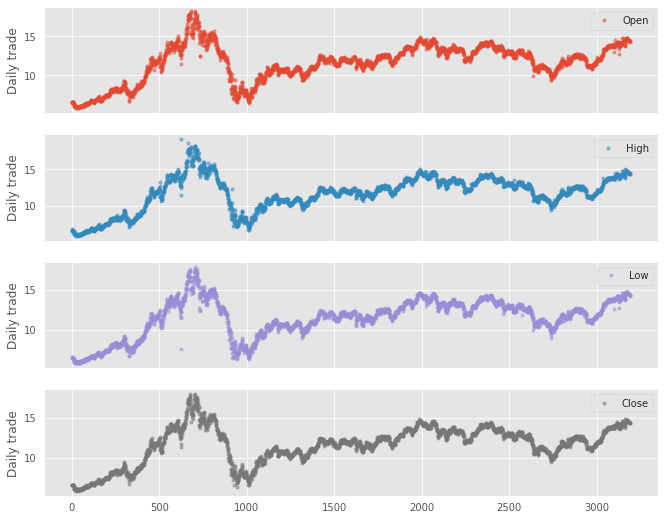

In [11]:
cols_plot = ['Open', 'High', 'Low','Close']
axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

Then we'd print the data after making changes and dropping null data

            Date     Open     High      Low    Close  Volume  OpenInt  \
0     2005-02-25   6.4987   6.6009   6.4668   6.5753   55766        0   
1     2005-02-28   6.6072   6.7669   6.5944   6.6263   49343        0   
2     2005-03-01   6.6391   6.6773   6.6072   6.6072   31643        0   
3     2005-03-02   6.5753   6.6072   6.5434   6.5816   27101        0   
4     2005-03-03   6.5753   6.6135   6.5562   6.5944   17387        0   
...          ...      ...      ...      ...      ...     ...      ...   
3185  2017-11-06  14.3998  14.4802  14.3900  14.4400   62423        0   
3186  2017-11-07  14.4400  14.4400  14.4000  14.4000    6722        0   
3187  2017-11-08  14.3400  14.4352  14.3400  14.3781    6304        0   
3188  2017-11-09  14.3300  14.3737  14.2800  14.3200   18761        0   
3189  2017-11-10  14.2500  14.3000  14.2400  14.3000   10658        0   

      MA for 10 days  MA for 50 days  MA for 100 days  Daily Return  
0           11.60878       11.625272        11.649354

,count,mean,std,min,25%,50%,75%,max
Open,3190.0,11.599416,2.350376,5.860300,10.534000,11.981000,13.271000,18.130000
High,3190.0,11.712848,2.365621,5.905000,10.655000,12.067000,13.386750,19.151000
Low,3190.0,11.484610,2.327065,5.834700,10.413750,11.899000,13.189000,17.842000
Close,3190.0,11.605599,2.341989,5.841100,10.554000,11.988500,13.295750,17.925000
Volume,3190.0,28444.870846,37525.175821,106.000000,8147.750000,17741.500000,36167.250000,634041.000000
OpenInt,3190.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MA for 10 days,3190.0,11.608780,2.321162,5.963080,10.577125,11.962700,13.297200,17.329400
MA for 50 days,3190.0,11.625272,2.231059,6.037646,10.591696,11.933450,13.269480,16.618460
MA for 100 days,3190.0,11.649354,2.113346,6.221377,10.632551,11.876775,13.200810,16.042560
Daily Return,3190.0,0.000388,0.017010,-0.130345,-0.006439,0.000484,0.007807,0.150503


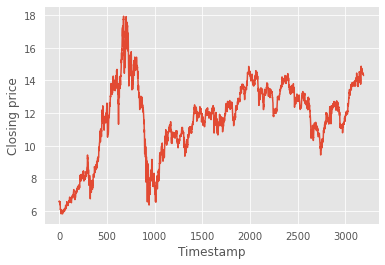

In [12]:
plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = data
print(df)

df.describe().transpose()

The data has been analysed but it must be converted into data of shape [100,1] to make it easier for CNN to train on... Else it won't select necessary features and the model will fail

In [13]:
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size=100
for i in range(1 , len(df) - window_size -1 , 1):
    first = df.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 2] - first) / first)
    temp2.append((df.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

2470
618


# Training part

This part has 2 subparts: CNN and LSTM

For CNN, the layers are created with sizes 64,128,64 with kernel size = 3. In every layer, TimeDistributed function is added to track the features for every temporal slice of data with respect to time. In between, MaxPooling layers are added.

After that, it's passed to Bi-LSTM layers

In [14]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

model = tf.keras.Sequential()

# Creating the Neural Network model here...
# CNN layers
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

#Final layers
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=40,batch_size=40, verbose=1, shuffle =True)

2021-12-21 04:10:12.460877: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-21 04:10:12.460997: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-21 04:10:17.052719: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-21 04:10:17.055455: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-21 04:10:17.055491: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-21 04:10:17.055523: I tensorflow/stream_executor/cuda/cud

Epoch 1/40
62/62 [==============================] - 11s 56ms/step - loss: 0.0114 - mse: 0.0114 - mae: 0.0775 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0490
Epoch 2/40
62/62 [==============================] - 1s 23ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0438 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0445
Epoch 3/40
62/62 [==============================] - 1s 23ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0420 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0417
Epoch 4/40
62/62 [==============================] - 1s 23ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0416 - val_loss: 0.0020 - val_mse: 0.0020 - val_mae: 0.0330
Epoch 5/40
62/62 [==============================] - 1s 23ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0340 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0326
Epoch 6/40
62/62 [==============================] - 1s 23ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0340 - val_loss: 0.0019 - val_mse: 0.0019 - val_mae: 0.0315
Epoch 7/40
62/62 [===

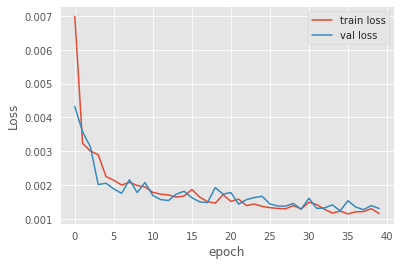

In [15]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

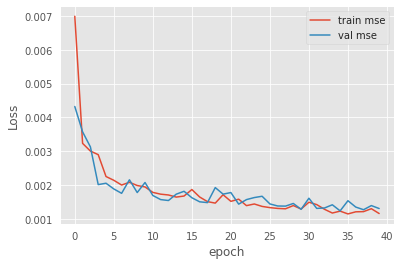

In [16]:
plt.plot(history.history['mse'], label='train mse')
plt.plot(history.history['val_mse'], label='val mse')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

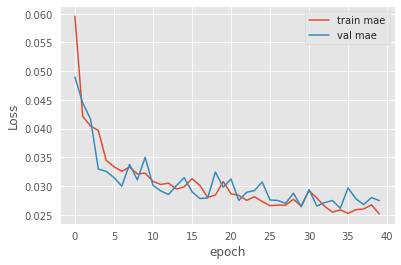

In [17]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 1, 98, 64)         256       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 49, 64)         0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 47, 128)        24704     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 23, 128)        0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 21, 64)         24640     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 10, 64)         0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 640)            0

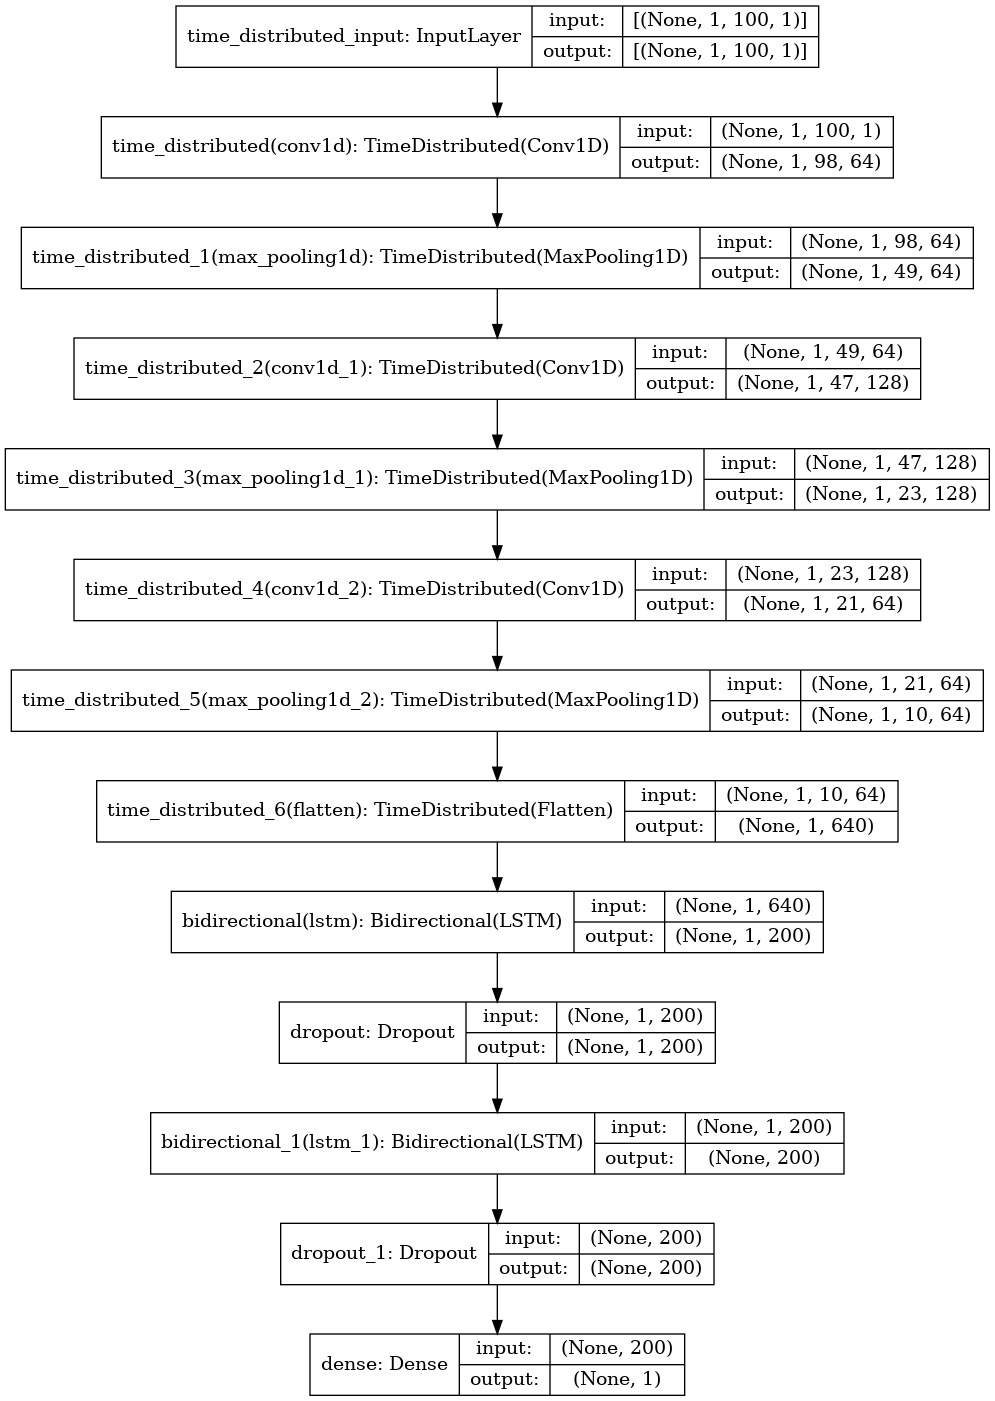

In [18]:
# After the model has been constructed, we'll summarise it
from tensorflow.keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [19]:
model.evaluate(test_X, test_Y)

20/20 [==============================] - 0s 7ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0275


[0.0013035156298428774, 0.0013035156298428774, 0.027480360120534897]

In [20]:
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

# predict probabilities for test set
yhat_probs = model.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(test_Y.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(test_Y.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(test_Y.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

Variance: 0.946135
R2 Score: 0.946135
Max Error: 0.167795


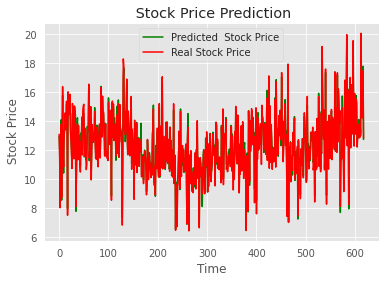

In [21]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

# Testing part

In this part, the model is saved and loaded back again. Then, it's made to train again but with different data to check it's loss and prediction

In [22]:
# First we need to save a model
model.save("model.h5")

In [23]:
# Load model
new_model = tf.keras.models.load_model("./model.h5")

In [24]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 1, 98, 64)         256       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 49, 64)         0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 47, 128)        24704     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 23, 128)        0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 21, 64)         24640     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 10, 64)         0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 640)            0

In [25]:
# For data preprocessing and analysis part
#data2 = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Stocks/aaoi.us.txt')
#data2 = pd.read_csv('../input/nifty50-stock-market-data/SBIN.csv')
#data2 = pd.read_csv('../input/stock-market-data/stock_market_data/nasdaq/csv/ACTG.csv')
data2 = pd.read_csv('./data.csv')
# Any CSV or TXT file can be added here....
data2.dropna(inplace=True)
data2.head()

data2.reset_index(drop=True, inplace=True)
data2.fillna(data.mean(), inplace=True)
data2.head()
df2 = data2.drop('date', axis=1)

print(df2)

X = []
Y = []
window_size=100
for i in range(1 , len(df2) - window_size -1 , 1):
    first = df2.iloc[i,4]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df2.iloc[i + j, 4] - first) / first)
    # for j in range(week):
    temp2.append((df2.iloc[i + window_size, 4] - first) / first)
    # X.append(np.array(stock.iloc[i:i+window_size,4]).reshape(50,1))
    # Y.append(np.array(stock.iloc[i+window_size,4]).reshape(1,1))
    # print(stock2.iloc[i:i+window_size,4])
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

      Unnamed: 0    open      high       low   close  adjusted close  \
0              0  125.72  127.2000  124.7000  127.06      127.060000   
1              1  125.87  128.6400  125.2093  127.40      127.400000   
2              2  123.51  126.6399  123.4750  125.93      125.930000   
3              3  123.80  124.8150  122.1800  123.11      123.110000   
4              4  122.35  125.0300  122.3000  123.76      123.760000   
...          ...     ...       ...       ...     ...             ...   
5566        5566   92.75   92.9400   90.1900   90.25       52.226608   
5567        5567   94.44   94.4400   90.0000   91.56       52.984689   
5568        5568   95.87   95.9400   93.5000   94.37       54.610803   
5569        5569   96.75   96.8100   93.6900   94.81       54.865426   
5570        5570   98.50   98.8100   96.3700   96.75       55.988081   

        volume  dividend amount  split cf  
0      4941411              0.0       1.0  
1     10382693              0.0       1.0  
2  

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()


4375
1094


In [26]:
model.evaluate(test_X, test_Y)

35/35 [==============================] - 0s 6ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0402


[0.002871885895729065, 0.002871885895729065, 0.0401865690946579]

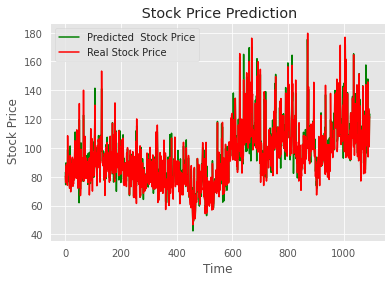

In [27]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data2.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [28]:
# Converting model from HDF5 format to TFJS format...
!pip install tensorflowjs[wizard]
# Need to be done on a CLI and not in notebook
!tensorflowjs_converter --input_format=keras /kaggle/working/model.h5 /kaggle/working/model-tjs

     |████████████████████████████████| 77 kB 1.7 MB/s eta 0:00:011
     |████████████████████████████████| 248 kB 4.4 MB/s eta 0:00:01
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-py3-none-any.whl size=32863 sha256=45532b843efdc2bde997fc820899cf314d8cd43c0d2e911e19493db9422ca76e
  Stored in directory: /root/.cache/pip/wheels/89/3b/7b/8b3cc8ac47137eabaeb6937a3ff0d33e78a12e2ba1e3ad4ba1
Successfully built PyInquirer
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 3.0.19
    Uninstalling prompt-toolkit-3.0.19:
      Successfully uninstalled prompt-toolkit-3.0.19
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 6.4.0 requires prompt-toolkit!=3.0.0,!=3.0.1,<3.1.0,>=2.0.0, but you have prompt-toolkit 1.0.14 which is incompatible.
ipython 7.26.0 requires prompt-toolkit!=3.0.0,!=3.0.1,<3.1.0,>=2.0.0, bu

# EDA

This section is exploratory data analysis on the dataset collected. This is just for analysing the data...

In [29]:
dataX = pd.read_csv('./data.csv')
dataY = pd.read_csv('./data.csv')
dataX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5571 entries, 0 to 5570
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       5571 non-null   int64  
 1   open             5571 non-null   float64
 2   high             5571 non-null   float64
 3   low              5571 non-null   float64
 4   close            5571 non-null   float64
 5   adjusted close   5571 non-null   float64
 6   volume           5571 non-null   int64  
 7   dividend amount  5571 non-null   float64
 8   split cf         5571 non-null   float64
 9   date             5571 non-null   object 
dtypes: float64(7), int64(2), object(1)
memory usage: 435.4+ KB


In [30]:
dataX.head()

,Unnamed: 0,open,high,low,close,adjusted close,volume,dividend amount,split cf,date
0,0,125.72,127.2000,124.7000,127.06,127.06,4941411,0.0,1.0,2021-12-20
1,1,125.87,128.6400,125.2093,127.40,127.40,10382693,0.0,1.0,2021-12-17
2,2,123.51,126.6399,123.4750,125.93,125.93,7280537,0.0,1.0,2021-12-16
3,3,123.80,124.8150,122.1800,123.11,123.11,4990028,0.0,1.0,2021-12-15
4,4,122.35,125.0300,122.3000,123.76,123.76,5716124,0.0,1.0,2021-12-14


In [31]:
start_date = '2020-01-01'
end_date = '2021-11-29'

start = '2018-01-01'
end = '2020-01-01'

fill = (dataX['date']>=start_date) & (dataX['date']<=end_date)
dataX = dataX.loc[fill]
dataX

,Unnamed: 0,open,high,low,close,adjusted close,volume,dividend amount,split cf,date
15,15,118.62,119.610,117.53,118.50,118.500000,8949795,0.0,1.0,2021-11-29
16,16,115.00,116.335,114.56,115.81,115.810000,3322012,0.0,1.0,2021-11-26
17,17,116.16,117.270,116.08,116.73,116.730000,3220802,0.0,1.0,2021-11-24
18,18,116.79,117.940,116.04,116.79,116.790000,4914995,0.0,1.0,2021-11-23
19,19,116.00,118.810,115.19,116.47,116.470000,6417218,0.0,1.0,2021-11-22
...,...,...,...,...,...,...,...,...,...,...
492,492,134.51,135.860,133.92,135.31,117.011071,4345952,0.0,1.0,2020-01-08
493,493,133.69,134.960,133.40,134.19,116.042537,3267592,0.0,1.0,2020-01-07
494,494,133.42,134.240,133.20,134.10,115.964708,2421128,0.0,1.0,2020-01-06
495,495,133.57,134.860,133.56,134.34,116.172251,2373470,0.0,1.0,2020-01-03


In [32]:
fill2 = (dataY['date']>=start) & (dataY['date']<=end)
dataY = dataY.loc[fill2]
dataY

,Unnamed: 0,open,high,low,close,adjusted close,volume,dividend amount,split cf,date
497,497,132.53,134.12,132.40,134.04,115.912822,3777504,0.0,1.0,2019-12-31
498,498,135.20,135.30,132.50,132.81,114.849164,4118929,0.0,1.0,2019-12-30
499,499,135.00,135.75,134.87,135.27,116.976481,2752185,0.0,1.0,2019-12-27
500,500,134.98,135.31,134.65,134.91,116.665166,2129654,0.0,1.0,2019-12-26
501,501,135.61,135.62,134.61,134.98,116.725700,1202087,0.0,1.0,2019-12-24
...,...,...,...,...,...,...,...,...,...,...
995,995,162.66,163.91,161.70,163.47,129.027615,5101023,0.0,1.0,2018-01-08
996,996,162.44,162.90,161.10,162.49,128.254097,5162075,0.0,1.0,2018-01-05
997,997,159.65,162.32,159.37,161.70,127.630546,7363843,0.0,1.0,2018-01-04
998,998,157.34,159.81,156.33,158.49,125.096879,9439063,0.0,1.0,2018-01-03


In [33]:
dataX.describe()

,Unnamed: 0,open,high,low,close,adjusted close,volume,dividend amount,split cf
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,4.820000e+02,482.000000,482.000000
mean,255.500000,129.382080,130.691720,128.092867,129.364751,117.791043,5.454950e+06,0.027095,1.000095
std,139.285678,11.382857,11.114856,11.592091,11.353678,11.831698,3.339331e+06,0.208783,0.002095
min,15.000000,94.600000,97.740000,90.560000,94.770000,82.819007,1.761122e+06,0.000000,1.000000
25%,135.250000,121.250000,122.623500,120.102500,121.105000,109.567533,3.644222e+06,0.000000,1.000000
50%,255.500000,126.325000,127.320000,125.045000,126.160000,115.419744,4.655173e+06,0.000000,1.000000
75%,375.750000,139.672500,140.467500,138.757500,139.572500,130.352392,6.115408e+06,0.000000,1.000000
max,496.000000,156.820000,158.750000,155.420000,156.760000,141.053047,3.806353e+07,1.640000,1.046000


In [34]:
dataY.describe()

,Unnamed: 0,open,high,low,close,adjusted close,volume,dividend amount,split cf
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,5.030000e+02,503.000000,503.0
mean,748.000000,140.470239,141.512740,139.348929,140.416143,115.933517,4.590926e+06,0.025129,1.0
std,145.347859,11.156349,11.144803,11.149435,11.121441,7.991439,2.880224e+06,0.197923,0.0
min,497.000000,108.000000,111.000000,105.940000,107.570000,88.768396,1.202087e+06,0.000000,1.0
25%,622.500000,134.485000,135.305000,133.570000,134.360000,114.105468,3.067226e+06,0.000000,1.0
50%,748.000000,140.720000,141.780000,139.790000,140.850000,116.651352,3.783614e+06,0.000000,1.0
75%,873.500000,146.635000,147.300000,145.540000,146.385000,120.536160,5.033500e+06,0.000000,1.0
max,999.000000,170.000000,171.130000,168.150000,169.120000,133.487186,2.206367e+07,1.620000,1.0


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


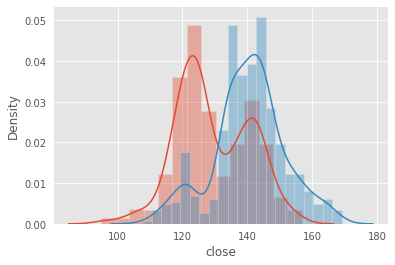

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error

sns_plot = sns.distplot(dataX['close'])
sns_plot2 = sns.distplot(dataY['close'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

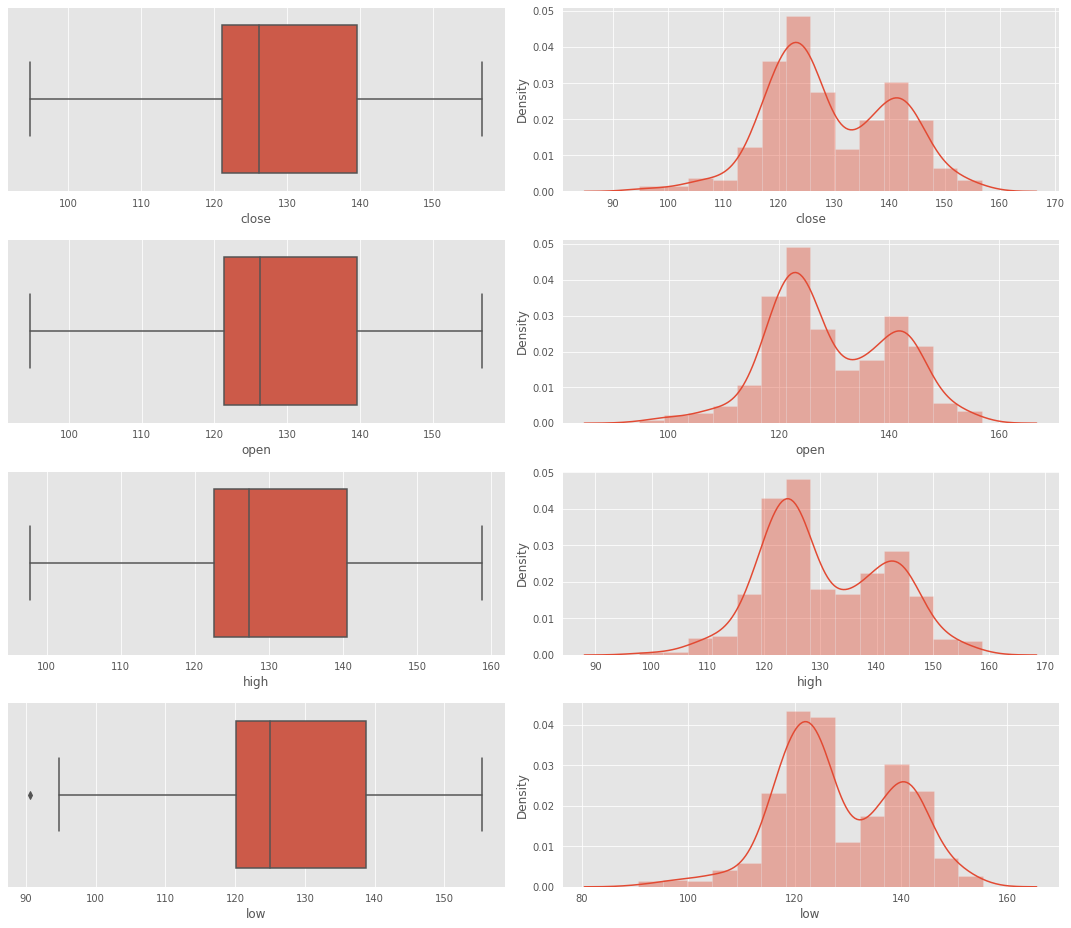

In [36]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataX["close"], ax = ax[0,0])
sns.distplot(dataX['close'], ax = ax[0,1])
sns.boxplot(x= dataX["open"], ax = ax[1,0])
sns.distplot(dataX['open'], ax = ax[1,1])
sns.boxplot(x= dataX["high"], ax = ax[2,0])
sns.distplot(dataX['high'], ax = ax[2,1])
sns.boxplot(x= dataX["low"], ax = ax[3,0])
sns.distplot(dataX['low'], ax = ax[3,1])
plt.tight_layout()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

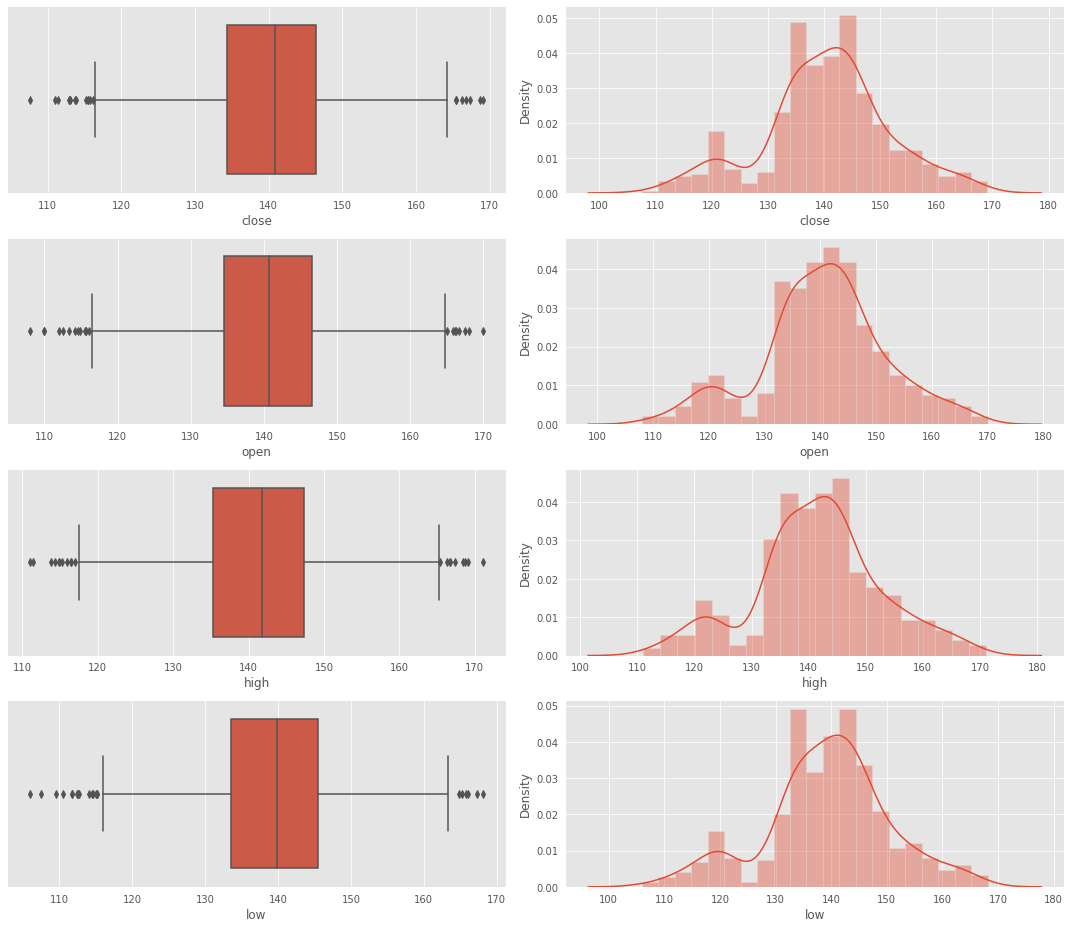

In [37]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataY["close"], ax = ax[0,0])
sns.distplot(dataY['close'], ax = ax[0,1])
sns.boxplot(x= dataY["open"], ax = ax[1,0])
sns.distplot(dataY['open'], ax = ax[1,1])
sns.boxplot(x= dataY["high"], ax = ax[2,0])
sns.distplot(dataY['high'], ax = ax[2,1])
sns.boxplot(x= dataY["low"], ax = ax[3,0])
sns.distplot(dataY['low'], ax = ax[3,1])
plt.tight_layout()

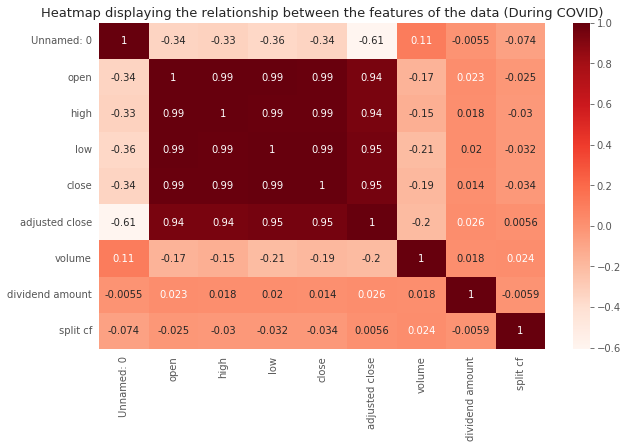

In [38]:
plt.figure(figsize=(10,6))
sns.heatmap(dataX.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (During COVID)',
         fontsize=13)
plt.show()

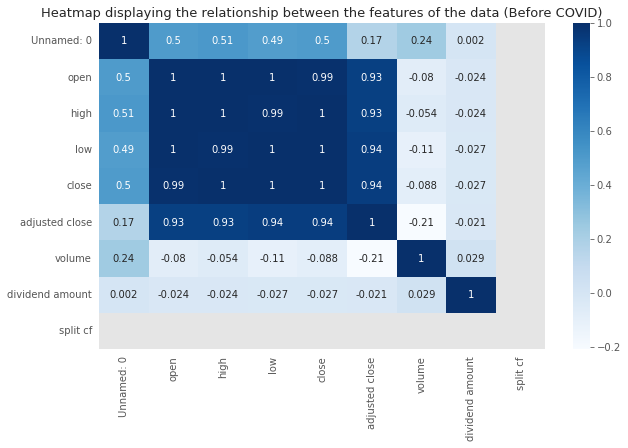

In [39]:
plt.figure(figsize=(10,6))
sns.heatmap(dataY.corr(),cmap=plt.cm.Blues,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (Before COVID)',
         fontsize=13)
plt.show()

In [40]:
# For other company....

# UNCOMMENT IF NEEDED...
cv2 = request_stock_price_list('RELIANCE.BSE', 'full', key)
print(cv2.head)
cv2.to_csv('data2.csv')

dataX = pd.read_csv('./data2.csv')
dataY = pd.read_csv('./data2.csv')
dataX.info()

Retrieving stock price data from Alpha Vantage (This may take a while)...
Data has been successfully downloaded...
Sorting the retrieved data into a dataframe...


100%|██████████| 4179/4179 [01:19<00:00, 52.55it/s]


<bound method NDFrame.head of            open       high       low      close adjusted close    volume  \
0        2315.0  2320.8999    2248.0     2277.2         2277.2   1104898   
1        2395.0    2408.75    2320.0  2341.1499      2341.1499    426622   
2        2404.0     2414.5    2369.0    2404.45        2404.45    147405   
3     2384.8501     2404.5   2361.75     2372.5         2372.5    271038   
4        2389.0     2406.0    2373.5  2380.3999      2380.3999    286591   
...         ...        ...       ...        ...            ...       ...   
4174   394.7115   409.2889  394.3751   404.3176        87.1294  16969845   
4175    392.469   401.0658  390.6747   393.1791         84.729  13446517   
4176   392.8427    399.197  385.9277   396.1319        85.3654  16954266   
4177   399.9444   407.3827  395.8329   396.8048        85.5104  10059943   
4178   388.7685   407.0464  388.7685   405.9997        87.4919  11842921   

     dividend amount split cf        date  
0            

In [41]:
start_date = '2020-01-01'
end_date = '2021-11-29'

start = '2018-01-01'
end = '2020-01-01'

fill = (dataX['date']>=start_date) & (dataX['date']<=end_date)
dataX = dataX.loc[fill]
dataX

,Unnamed: 0,open,high,low,close,adjusted close,volume,dividend amount,split cf,date
15,15,2412.0000,2500.0000,2400.0000,2442.5000,2442.5000,451870,0.0,1.0,2021-11-29
16,16,2470.0000,2477.4500,2403.0000,2412.1499,2412.1499,397321,0.0,1.0,2021-11-26
17,17,2375.5000,2502.8000,2358.0000,2494.3999,2494.3999,476931,0.0,1.0,2021-11-25
18,18,2381.3999,2410.8501,2344.0000,2350.8999,2350.8999,1856369,0.0,1.0,2021-11-24
19,19,2339.0000,2401.5000,2309.3999,2386.1499,2386.1499,457139,0.0,1.0,2021-11-23
...,...,...,...,...,...,...,...,...,...,...
484,484,1519.9995,1533.9995,1514.4495,1525.0495,1500.1978,509038,0.0,1.0,2020-01-07
485,485,1526.9995,1527.9995,1497.4995,1501.4995,1477.0316,457443,0.0,1.0,2020-01-06
486,486,1534.3995,1541.2995,1523.3995,1537.2495,1512.1990,357456,0.0,1.0,2020-01-03
487,487,1513.9995,1540.7995,1512.9995,1535.3495,1510.3299,733200,0.0,1.0,2020-01-02


In [42]:
fill2 = (dataY['date']>=start) & (dataY['date']<=end)
dataY = dataY.loc[fill2]
dataY

,Unnamed: 0,open,high,low,close,adjusted close,volume,dividend amount,split cf,date
488,488,1516.0995,1527.3995,1505.3495,1509.6995,1485.0979,461171,0.0,1.0,2020-01-01
489,489,1544.6995,1544.6995,1509.0995,1514.0995,1489.4262,298520,0.0,1.0,2019-12-31
490,490,1542.9995,1546.9995,1528.2995,1544.1995,1519.0357,374974,0.0,1.0,2019-12-30
491,491,1524.9995,1545.7995,1521.4495,1542.1495,1517.0191,490080,0.0,1.0,2019-12-27
492,492,1545.9495,1553.2995,1510.9495,1515.9495,1491.2461,582675,0.0,1.0,2019-12-26
...,...,...,...,...,...,...,...,...,...,...
973,973,920.4997,925.8497,919.4497,922.9997,897.4240,410556,0.0,1.0,2018-01-05
974,974,918.9997,921.7997,915.9997,920.2497,894.7502,241196,0.0,1.0,2018-01-04
975,975,924.4497,927.1997,913.2997,916.3497,890.9583,520663,0.0,1.0,2018-01-03
976,976,914.9997,919.1997,907.2497,911.3997,886.1454,1779802,0.0,1.0,2018-01-02


In [43]:
dataX.describe()

,Unnamed: 0,open,high,low,close,adjusted close,volume,dividend amount,split cf
count,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,4.740000e+02,474.000000,474.000000
mean,251.500000,1953.239692,1977.124080,1925.387901,1949.614691,1941.479689,1.148593e+06,0.028481,1.000020
std,136.976275,378.827940,377.669256,377.601744,377.490721,383.669825,6.773073e+06,0.438297,0.000437
min,15.000000,919.999700,951.999700,875.699700,883.849700,869.446800,6.484700e+04,0.000000,1.000000
25%,133.250000,1731.837500,1754.662500,1714.137500,1729.987500,1717.989700,2.998212e+05,0.000000,1.000000
50%,251.500000,2013.850000,2045.550000,1990.925000,2007.300000,2000.862500,4.758745e+05,0.000000,1.000000
75%,369.750000,2170.825000,2194.675000,2139.500000,2167.175000,2163.562475,9.260610e+05,0.000000,1.000000
max,488.000000,2740.000000,2750.000000,2708.000000,2731.500000,2731.500000,1.187279e+08,7.000000,1.009516


In [44]:
dataY.describe()

,Unnamed: 0,open,high,low,close,adjusted close,volume,dividend amount,split cf
count,490.00000,490.000000,490.000000,490.000000,490.000000,490.000000,4.900000e+02,490.000000,490.0
mean,732.50000,1182.485761,1194.496168,1168.685966,1181.144638,1155.626630,5.672558e+05,0.025270,1.0
std,141.59508,185.207018,186.587684,182.842687,184.419946,184.076833,5.363404e+05,0.395444,0.0
min,488.00000,879.999700,895.999700,872.099700,882.799700,858.337900,1.488160e+05,0.000000,1.0
25%,610.25000,999.624700,1012.524700,990.762200,1002.462200,974.684650,3.096382e+05,0.000000,1.0
50%,732.50000,1207.499600,1223.449600,1195.999600,1210.324600,1184.755450,4.345385e+05,0.000000,1.0
75%,854.75000,1297.999600,1314.699600,1283.862100,1296.824600,1271.188050,6.224218e+05,0.000000,1.0
max,977.00000,1611.199500,1617.799500,1595.649500,1605.149500,1578.992500,6.718394e+06,6.438700,1.0


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


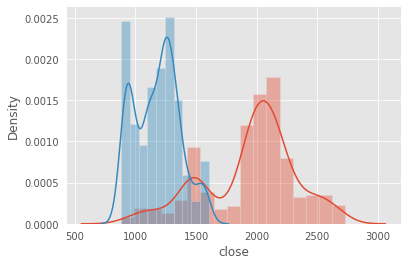

In [45]:
sns_plot = sns.distplot(dataX['close'])
sns_plot2 = sns.distplot(dataY['close'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

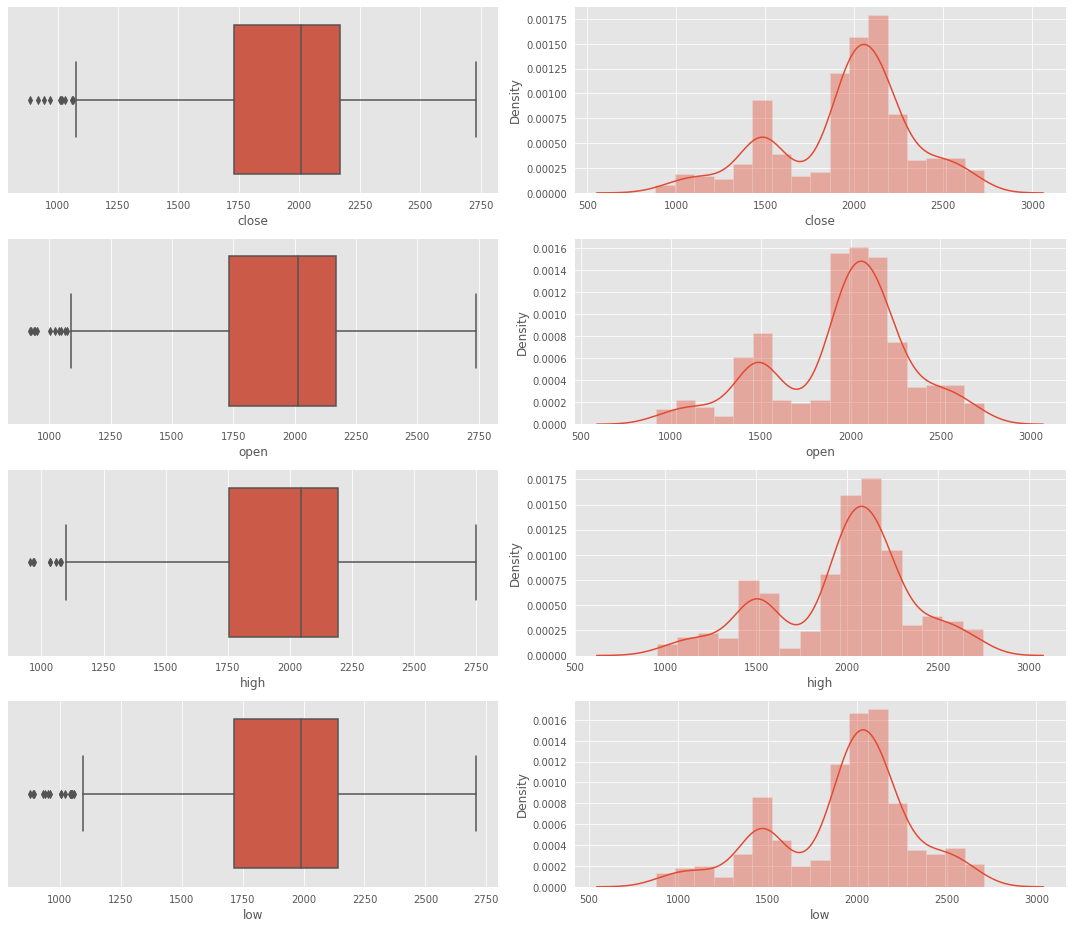

In [46]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataX["close"], ax = ax[0,0])
sns.distplot(dataX['close'], ax = ax[0,1])
sns.boxplot(x= dataX["open"], ax = ax[1,0])
sns.distplot(dataX['open'], ax = ax[1,1])
sns.boxplot(x= dataX["high"], ax = ax[2,0])
sns.distplot(dataX['high'], ax = ax[2,1])
sns.boxplot(x= dataX["low"], ax = ax[3,0])
sns.distplot(dataX['low'], ax = ax[3,1])
plt.tight_layout()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

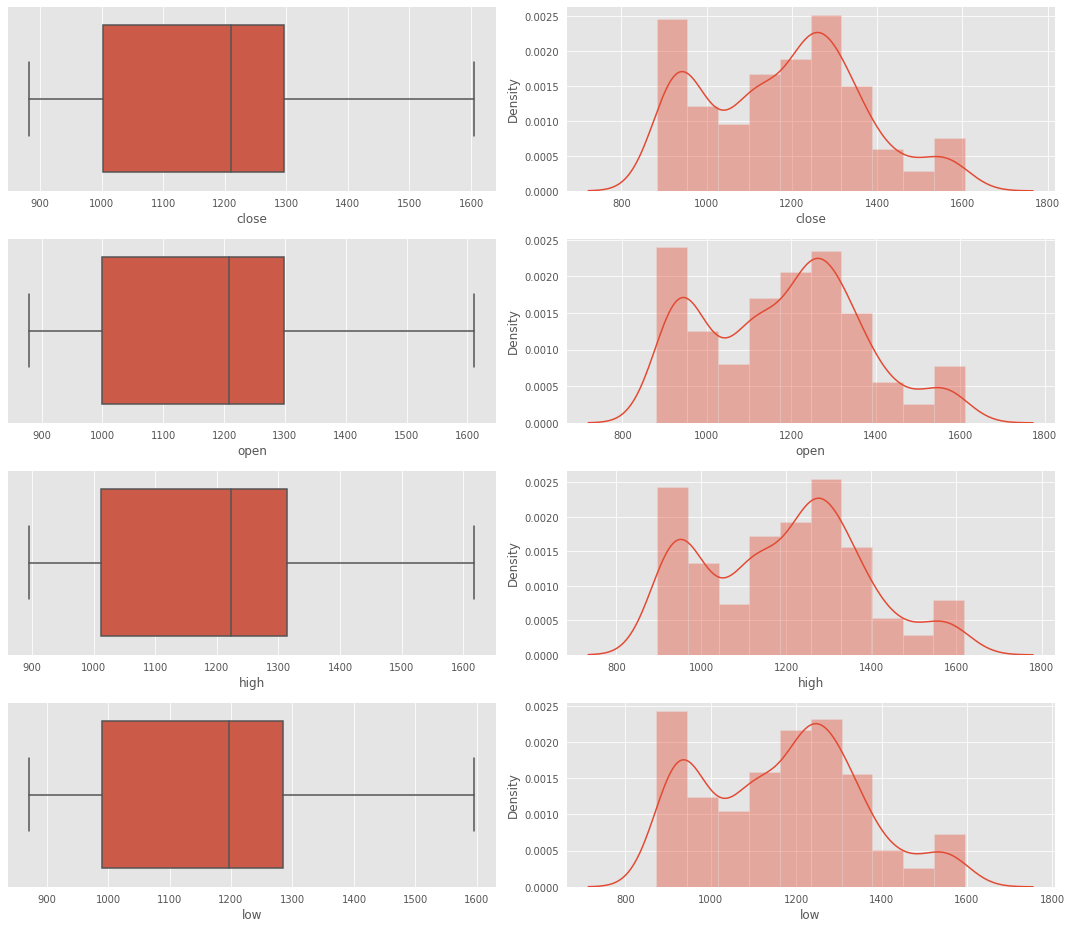

In [47]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataY["close"], ax = ax[0,0])
sns.distplot(dataY['close'], ax = ax[0,1])
sns.boxplot(x= dataY["open"], ax = ax[1,0])
sns.distplot(dataY['open'], ax = ax[1,1])
sns.boxplot(x= dataY["high"], ax = ax[2,0])
sns.distplot(dataY['high'], ax = ax[2,1])
sns.boxplot(x= dataY["low"], ax = ax[3,0])
sns.distplot(dataY['low'], ax = ax[3,1])
plt.tight_layout()

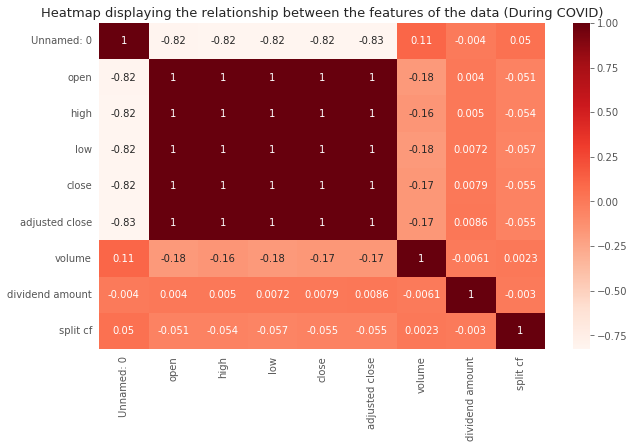

In [48]:
plt.figure(figsize=(10,6))
sns.heatmap(dataX.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (During COVID)',
         fontsize=13)
plt.show()

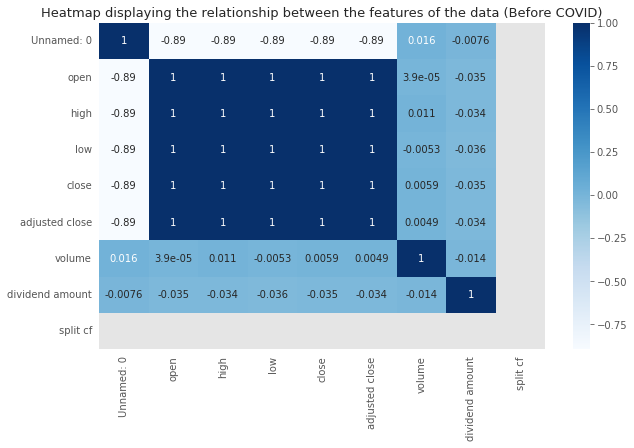

In [49]:
plt.figure(figsize=(10,6))
sns.heatmap(dataY.corr(),cmap=plt.cm.Blues,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (Before COVID)',
         fontsize=13)
plt.show()